# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch. Except the calculation of gradients, for which we rely on the functionality provided by PyTorch. 

The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

Part of the code in the notebook is based on the tutorial at https://pytorch.org/tutorials/beginner/nn_tutorial.html

First we import the modules used in this selfstudy

In [49]:
import torch
from pathlib import Path
import requests
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pickle
import gzip

The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set, validation set, and test set consisting of $50000$, $10000$, and $10000$ images, respectively; in all data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

First we download the dataset and unpackage it.

In [50]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

We then extract the data and store it numpy arrays: x_train, y_train, x_valid, y_valid, x_test, y_test 

In [51]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

Check the shape of the x_valid holding the validation data

In [52]:
x_valid.shape

(10000, 784)

The images are stored in rows of length $784$, hence to display the images we need to reshape them to $28\times 28$.

(50000, 784)


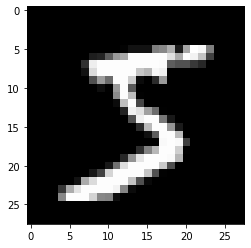

In [53]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In order to take adavntage of PyTorch support for calculating gradients, we need to convert the numpy arrays to PyTorch tensors. See the code example from the last lecture on PyTorch's support for automatic gradient calculation using the back propagation algorithm.

In [112]:
x_train, y_train, x_valid, y_valid, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(f"Training data (images): \n {x_train}")
print(f"Training data (labels): \n {y_train}")
print(f"Shape of x_train (now torch tensor) holding the training images: {x_train.shape}")
print(f"Min and max label values: {y_train.min()}, {y_train.max()}")

Training data (images): 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Training data (labels): 
 tensor([5, 0, 4,  ..., 8, 4, 8])
Shape of x_train (now torch tensor) holding the training images: torch.Size([50000, 784])
Min and max label values: 0, 9


For the first part of this self study we will specify a neural network, which will encode a [softmax function](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#softmax-and-probabilities). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. 

We store our weights (and biases) in a matrix structure so that the combination of inputs and weights can be expressed as one single matrix multiplication.

In [106]:
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Out model specification

In [152]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

# Below @ refers to matrix multiplication
def model(weights, bias, xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights) using a so-called batch size of 64 (more on this later in the note book); for the prediction we pick out the first element in the batch.

**Note:** During the lecture we didn't have time to cover learning with batches. Before continuing, please revisit the slides/literature from lecture (in particular Slides 26 and 27) and try to get the gist of this on your own. We will discuss it further at the next lecture on Thursday. 

In [58]:
batch_size = 64
xb = x_train[0:batch_size]
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

Batch shape: torch.Size([64, 784])
Prediction on first image tensor([0.1316, 0.0811, 0.0974, 0.0822, 0.1119, 0.0894, 0.0859, 0.1058, 0.0917,
        0.1229], grad_fn=<SelectBackward>)
Corresponding classification: 0


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [59]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean()

loss_func = nll

# Make a test calculation
yb = y_train[0:batch_size]
print(loss_func(preds,yb))

tensor(2.3130, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [60]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [61]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.078125


Now we are ready to combine it all and perform learning

In [155]:
def train(weights, bias, w_momen=None, b_momen=None, epochs=10, lr=0.01, batch_size=64, shall_print=False, train_losses=[], alpha=0.3):
    # We recorded the losses in lists for later plotting
    valid_losses = []

    # Iterate for a fixed number of epochs. One epoch is an iteration of the data set, read in chucks of size batch_size
    for epoch in range(epochs):
        for batch_idx in range((n - 1) // batch_size + 1):

            # pick out the relevant batch
            start_i = batch_idx * batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            # Do prediction for all elements in the batch
            pred = model(weights, bias, xb)
            # and calculate the loss
            loss = loss_func(pred, yb)

            # Do back propagation to find the gradients
            loss.backward()
            with torch.no_grad():
                # Update the weights
                if w_momen == None:
                    weights -= weights.grad * lr
                else:
                    change = weights.grad * lr + alpha * w_momen
                    w_momen = change
                    weights -= change

                if b_momen == None:
                    bias -= bias.grad * lr
                else:
                    change = bias.grad * lr + alpha * b_momen
                    b_momen = change
                    bias -= change
                
                weights.grad.zero_()
                bias.grad.zero_()

                if batch_idx % 100 == 0:
                    with torch.no_grad():
                        train_loss = loss_func(model(weights, bias, x_train), y_train)
                        
                        if shall_print:
                            print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                        
                        train_losses.append(train_loss)

    return train_losses, weights, bias, w_momen, b_momen

Epoch: 0, B-idx: 0, Training loss: 0.39805126190185547
Epoch: 0, B-idx: 100, Training loss: 0.3956129252910614
Epoch: 0, B-idx: 200, Training loss: 0.3947996497154236
Epoch: 0, B-idx: 300, Training loss: 0.39415061473846436
Epoch: 0, B-idx: 400, Training loss: 0.3940183222293854
Epoch: 0, B-idx: 500, Training loss: 0.39372968673706055
Epoch: 0, B-idx: 600, Training loss: 0.39359188079833984
Epoch: 0, B-idx: 700, Training loss: 0.3936447203159332
Epoch: 1, B-idx: 0, Training loss: 0.39363962411880493
Epoch: 1, B-idx: 100, Training loss: 0.39344239234924316
Epoch: 1, B-idx: 200, Training loss: 0.39324039220809937
Epoch: 1, B-idx: 300, Training loss: 0.3930177390575409
Epoch: 1, B-idx: 400, Training loss: 0.3931111693382263
Epoch: 1, B-idx: 500, Training loss: 0.3928245007991791
Epoch: 1, B-idx: 600, Training loss: 0.39274492859840393
Epoch: 1, B-idx: 700, Training loss: 0.3927977383136749
Epoch: 2, B-idx: 0, Training loss: 0.39275601506233215
Epoch: 2, B-idx: 100, Training loss: 0.392601

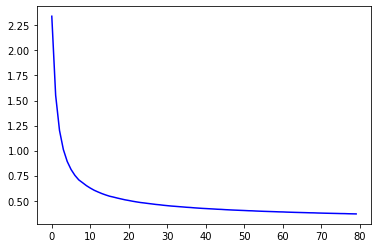

In [156]:
train(weights, bias, shall_print=True)
plt.plot(range(len(train_losses)), train_losses,'b')

Plot the evolution of the training loss

In [161]:
import time

def init_parameters():
    torch.manual_seed(13) # ensure reproducability ..
    weights = torch.randn(784, 10) / np.sqrt(784)
    weights.requires_grad_()
    bias = torch.zeros(10, requires_grad=True)
    
    return weights, bias

def timed_run(weights, bias, w_momen=None, b_momen=None, duration_min=0.25, lr=0.1, batch_size=64, alpha=0.3):
    init_t = time.time()
    losses, weights, bias, w_momen, b_momen = train(weights, bias, w_momen=w_momen, b_momen=b_momen, epochs=1, lr=lr, batch_size=batch_size, train_losses=[], alpha=alpha)
    
    while time.time() - init_t < duration_min * 60:
        losses, weights, bias, w_momen, b_momen = train(weights, bias, w_momen=w_momen, b_momen=b_momen, epochs=1, lr=lr, batch_size=batch_size, train_losses=losses, alpha=alpha)
    
    plt.plot(range(len(losses)), losses,'b')
    plt.show()

    return weights, bias

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results? 
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set (for inspiration, see Line 23 above).

baseline:


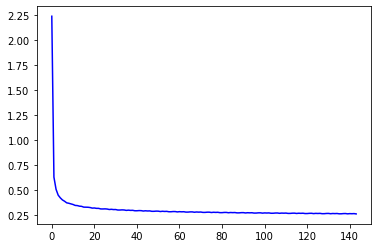

higher learning rate:


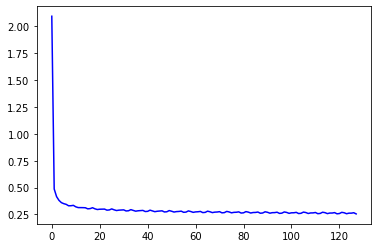

smaller batch size:


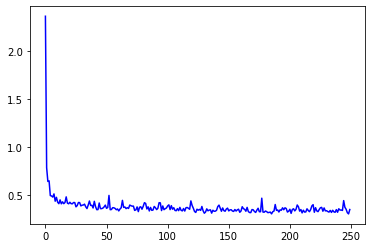

In [158]:
weights, bias = init_parameters()
print("baseline:")
timed_run(weights, bias)
weights, bias = init_parameters()
print("higher learning rate:")
timed_run(weights, bias, lr=0.3)
weights, bias = init_parameters()
print("smaller batch size:")
timed_run(weights, bias, batch_size=4)

With momentum (alpha 0.9):


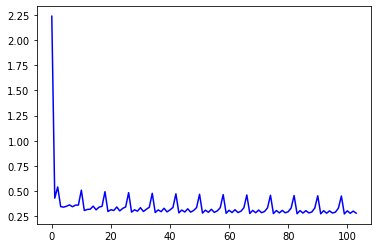

In [159]:
weights, bias = init_parameters()
w_momen = torch.zeros(784, 10, requires_grad=False)
b_momen = torch.zeros(10, requires_grad=False)
print("With momentum (alpha 0.9):")
timed_run(weights, bias, w_momen=w_momen, b_momen=b_momen, alpha=0.9)

random bias; Greater max values:


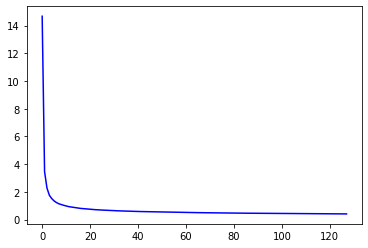

loss starts much greater, but the end result is about the same.


In [160]:
def init_parameters_rand():
    torch.manual_seed(13) # ensure reproducability ..
    weights = torch.randn(784, 10)
    weights.requires_grad_()
    bias = torch.randn(10)
    bias.requires_grad_()
    
    return weights, bias

weights, bias = init_parameters_rand()
print("random bias; Greater max values:")
timed_run(weights, bias)
print("loss starts much greater, but the end result is about the same.")

baseline:


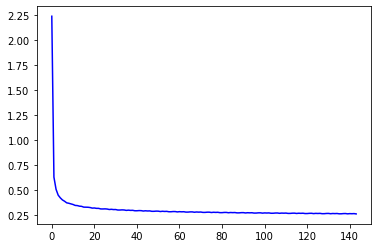

Accuracy of model on test dataset: 0.9215999841690063


In [162]:
weights, bias = init_parameters()
print("baseline:")
weights, bias = timed_run(weights, bias)
preds = model(weights, bias, x_test)
print(f"Accuracy of model on test dataset: {accuracy(preds, y_test)}")